In [1]:
from PIL import ImageFont, ImageDraw, Image
import numpy as np


BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
CHARS_PER_ROW = 50
MONOSPACE_FONT_RATIO = 0.6


def text_to_image(text: str, shape: tuple[int, int]) -> Image:
    shape = (shape[1], shape[0])
    
    font_size = shape[0] // int(CHARS_PER_ROW * MONOSPACE_FONT_RATIO)
    n_rows = shape[1] // font_size

    if len(text) > CHARS_PER_ROW * n_rows:
        print(f"Text is to big, {len(text) - CHARS_PER_ROW * n_rows} chars will be stripped")
        text = text[:CHARS_PER_ROW * n_rows]

    font = ImageFont.truetype("./dataset/font.ttf", font_size)
    # font = ImageFont.load_default()

    text_img = Image.new('RGB', shape, color=BLACK)
    drawer = ImageDraw.Draw(text_img)
    
    for i in range(n_rows):
        drawer.text((0, i * font_size), 
                    text[i * CHARS_PER_ROW: (i + 1) * CHARS_PER_ROW], 
                    fill=WHITE, font=font)
    
    return text_img


def normalize_image(img: np.ndarray) -> np.ndarray:
    if img.dtype == np.uint8:
        img = img[:,:,:3] / 255.0
        
    return img[:, :, :3].astype(np.float64)


def denormalize_image(img: np.ndarray) -> np.ndarray:
    if img.dtype != np.uint8:
        # img, _, _ = centralize(img)
        img = np.clip(img, 0, 1) * 255
        
    return img[:, :, :3].astype(np.uint8)


def centralize(img: np.ndarray, side = 0.06):
    img = img.real.astype(np.float64)
    thres = img.size * side
    
    l = img.min()
    r = img.max()
    while l + 1 <= r:
        m = (l + r) / 2.
        s = np.sum(img < m)
        if s < thres:
            l = m
        else:
            r = m
    low = l            
            
    l = img.min()
    r = img.max()
    while l + 1 <= r:
        m = (l + r) / 2.
        s = np.sum(img > m)
        if s < thres:
            r = m
        else:
            l = m            
            
    high = max(low + 1, r)          
    img = (img - low) / (high - low)
    
    return img, low, high


def get_xmap(shape):
    return np.arange(shape[0]).reshape((-1, 1)), np.arange(shape[1])

In [ ]:

def embed(img: Image, text: str) -> Image:
    img = normalize_image(np.asarray(img))
    embedding_zone_shape = (img.shape[0] // 2, img.shape[1])
    
    text_img = text_to_image(text, embedding_zone_shape)
    text_img = normalize_image(np.asarray(text_img))
    
    img_fft = np.fft.fft2(img, None, (0, 1))
    
    _, low, high = centralize(img_fft)
    alpha = high - low
    
    xmap = get_xmap(embedding_zone_shape)
    
    img_fft[xmap[0], xmap[1]] += text_img * alpha
    img_fft[-xmap[0], -xmap[1]] += text_img * alpha
    
    img_inv = np.fft.ifft2(img_fft, None, (0, 1)).real
    
    return denormalize_image(img_inv)

    
def extract(img: Image, base_img: Image) -> Image:
    img = normalize_image(np.asarray(img))
    base_img = normalize_image(np.asarray(base_img))
    
    img_fft = np.fft.fft2(img, None, (0, 1))
    base_img_fft = np.fft.fft2(base_img, None, (0, 1))
    
    img_fft -= base_img_fft
    
    xmap = get_xmap((img.shape[0] // 2, img.shape[1]))
    
    embedding_zone, _, _ = centralize(img_fft[xmap[0], xmap[1]])
    
    return denormalize_image(embedding_zone)

(2301, 3068, 3)


TypeError: Image data of dtype complex128 cannot be converted to float

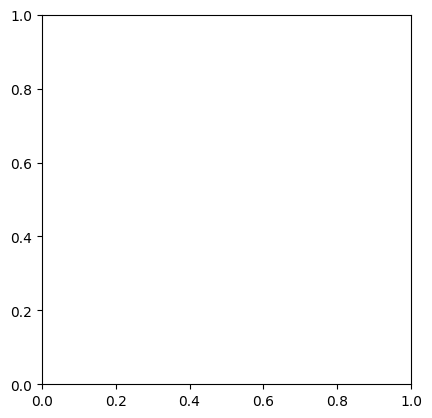

In [3]:


img = Image.open("./dataset/cover.jpg")


res = embed(img, "Hello, Steganography!")

# noise
from utils.noise import add_gaussian_noise
res = add_gaussian_noise(image=res, mean=0, sigma=5)

Image.fromarray(res).save("./results/stego_fft_n.png")

    


In [ ]:

base_img = Image.open("./results/stego_fft_n.png")

res = extract(img, base_img)
Image.fromarray(res).save("./results/secret_fft_n.png")
    


